# Assignment 01: Simple & Multiple Linear Regression
## Medical Insurance Cost Prediction (Synthetic Dataset)

## Learning goals
By the end of this assignment you should be able to:
- Load and explore tabular data with pandas
- Prepare features for linear regression (numeric + categorical)
- Fit **simple** and **multiple** linear regression models with scikit-learn
- Interpret model coefficients and evaluate models with **R²**, **RMSE**, and **MAE**
- Use residual plots to diagnose model issues

## Allowed libraries
You may use:
- `numpy`, `pandas`, `matplotlib`
- `scikit-learn` (sklearn)

Do **not** use AutoML packages.

---
## Dataset note
This notebook uses a **synthetic** medical insurance dataset generated.
Treat the workflow as you would with a real dataset.

In [1]:
# If you get an import error, install packages via:
# !pip install numpy pandas matplotlib scikit-learn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Dataset: Medical Insurance Costs (Synthetic)

Each row represents one person:
- **age**: years (18–64)
- **bmi**: body mass index
- **children**: number of children
- **sex**: female / male
- **smoker**: yes / no
- **region**: northeast / northwest / southeast / southwest
- **charges**: annual medical cost (USD) — **target**

---
# Q1 — Data loading and exploration (15 points)

1. Load `insurance_synth.csv` into a DataFrame called `df`. (2 pts)  
2. Print: shape, column names, and `df.head()`. (3 pts)  
3. Compute summary statistics for numeric columns. (3 pts)  
4. Check for missing values and report any columns with missing data. (3 pts)  
5. Make two plots (matplotlib):
   - Histogram of `charges` (2 pts)
   - Scatter plot of `bmi` vs `charges` (2 pts)  
6. **Discussion (markdown, 2–4 sentences):** Describe the distribution of charges (skew/outliers). (2 pts)

In [14]:
# Q1.1: Load CSV into df
df = pd.read_csv("insurance_synth.csv")

# Q1.2: Print shape, columns, head
print("Shape:", df.shape)
print("\nColumn names:", df.columns.tolist())
print("\nFirst 5 rows:")
df.head()

Shape: (1338, 7)

Column names: ['age', 'bmi', 'children', 'sex', 'smoker', 'region', 'charges']

First 5 rows:


,age,bmi,children,sex,smoker,region,charges
0,22,28.0,0,male,no,southwest,3210.97
1,54,29.1,2,male,no,northwest,11614.19
2,48,33.7,5,male,no,northwest,10669.31
3,38,19.6,3,female,yes,northeast,28299.70
4,38,31.0,1,male,no,southwest,5249.06


In [3]:
# Q1.3: Summary statistics (numeric)
print("Summary statistics for numeric columns:")
df.describe()

Summary statistics for numeric columns:


,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,41.393124,29.614798,2.492526,12608.470389
std,13.534665,6.019495,1.719792,10583.903649
min,18.000000,16.000000,0.000000,200.000000
25%,30.000000,25.600000,1.000000,5556.085000
50%,42.000000,29.900000,2.000000,8640.250000
75%,53.000000,33.700000,4.000000,14743.252500
max,64.000000,49.100000,5.000000,42282.180000


In [4]:
# Q1.4: Missing values
print("Missing values per column:")
missing = df.isnull().sum()
print(missing)
print(f"\nTotal missing values: {missing.sum()}")

Missing values per column:
age         0
bmi         0
children    0
sex         0
smoker      0
region      0
charges     0
dtype: int64

Total missing values: 0


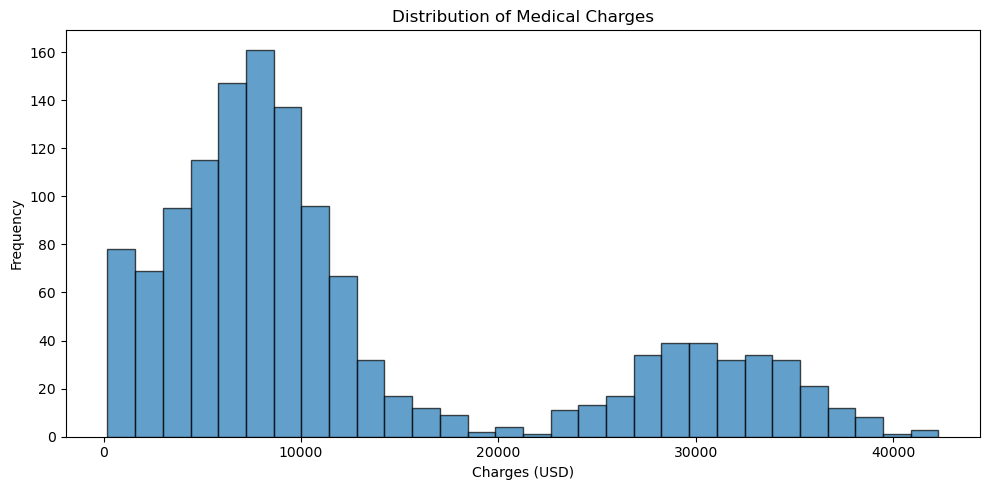

In [5]:
# Q1.5: Histogram of charges
plt.figure(figsize=(10, 5))
plt.hist(df['charges'], bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Charges (USD)')
plt.ylabel('Frequency')
plt.title('Distribution of Medical Charges')
plt.tight_layout()
plt.show()

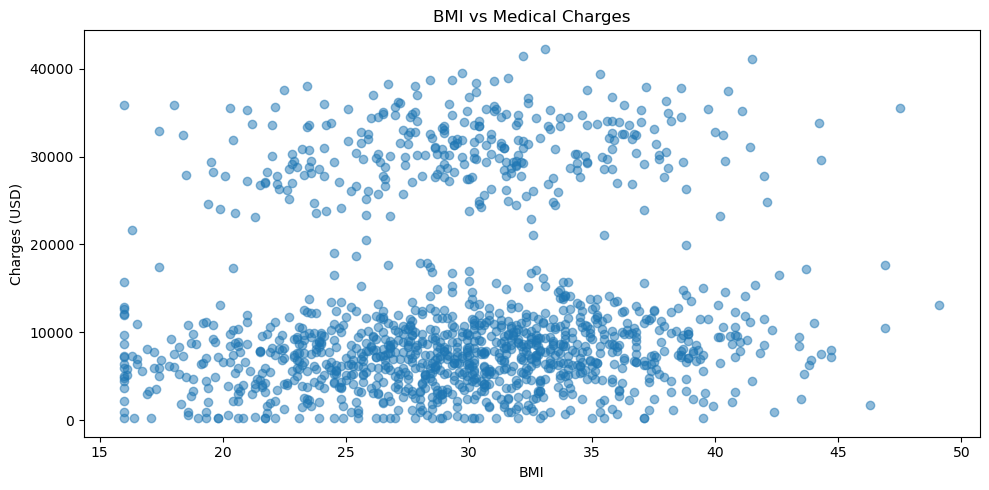

In [6]:
# Q1.5: Scatter plot of bmi vs charges
plt.figure(figsize=(10, 5))
plt.scatter(df['bmi'], df['charges'], alpha=0.5)
plt.xlabel('BMI')
plt.ylabel('Charges (USD)')
plt.title('BMI vs Medical Charges')
plt.tight_layout()
plt.show()

**Q1.6 Discussion:**

The charges distribution is right-skewed with most values below $15k and some high outliers above $40k. The BMI vs charges scatter plot shows two distinct clusters, probably smokers vs non-smokers.

---
# Q2 — Feature engineering (15 points)

1. Create `bmi_category` with categories:
   - `underweight` (<18.5)
   - `normal` (18.5–24.9)
   - `overweight` (25–29.9)
   - `obese` (30+)  (6 pts)
2. Create a binary feature `is_high_bmi` that is 1 if `bmi >= 30` else 0. (3 pts)  
3. Create `age_decade` = floor(age/10)*10 (e.g., 34 → 30). (3 pts)  
4. **Discussion (markdown):** Why do we one-hot encode categorical variables for linear regression? (3 pts)

In [7]:
# Q2.1: bmi_category
bins = [0, 18.5, 25, 30, float('inf')]
labels = ['underweight', 'normal', 'overweight', 'obese']
df['bmi_category'] = pd.cut(df['bmi'], bins=bins, labels=labels, right=False)

# Q2.2: is_high_bmi
df['is_high_bmi'] = (df['bmi'] >= 30).astype(int)

# Q2.3: age_decade
df['age_decade'] = (df['age'] // 10) * 10

# Quick sanity check
df[['bmi', 'bmi_category', 'is_high_bmi', 'age', 'age_decade']].head(10)

,bmi,bmi_category,is_high_bmi,age,age_decade
0,28.0,overweight,0,22,20
1,29.1,overweight,0,54,50
2,33.7,obese,1,48,40
3,19.6,normal,0,38,30
4,31.0,obese,1,38,30
5,27.7,overweight,0,58,50
6,41.1,obese,1,22,20
7,29.0,overweight,0,50,50
8,40.0,obese,1,27,20
9,23.4,normal,0,22,20


**Q2.4 Discussion:**

We need one-hot encoding because linear regression only works with numbers. Categories like "northeast" or "southwest" don't have a natural order, so we can't just assign them 1,2,3,4. One-hot creates separate 0/1 columns for each category so the model can learn each effect independently.

---
# Q3 — Correlation and multicollinearity (10 points)

1. Compute the correlation matrix for numeric columns. (3 pts)  
2. Visualize it using `plt.imshow` (no seaborn). (4 pts)  
3. Print the **top 3** numeric features most correlated with `charges` (absolute correlation). (3 pts)

Correlation Matrix:
                  age       bmi  children   charges  is_high_bmi  age_decade
age          1.000000 -0.012619  0.001797  0.026038     0.003130    0.978248
bmi         -0.012619  1.000000  0.039321  0.091040     0.796514   -0.015818
children     0.001797  0.039321  1.000000  0.079242     0.030364   -0.007153
charges      0.026038  0.091040  0.079242  1.000000     0.067316    0.016529
is_high_bmi  0.003130  0.796514  0.030364  0.067316     1.000000   -0.004603
age_decade   0.978248 -0.015818 -0.007153  0.016529    -0.004603    1.000000


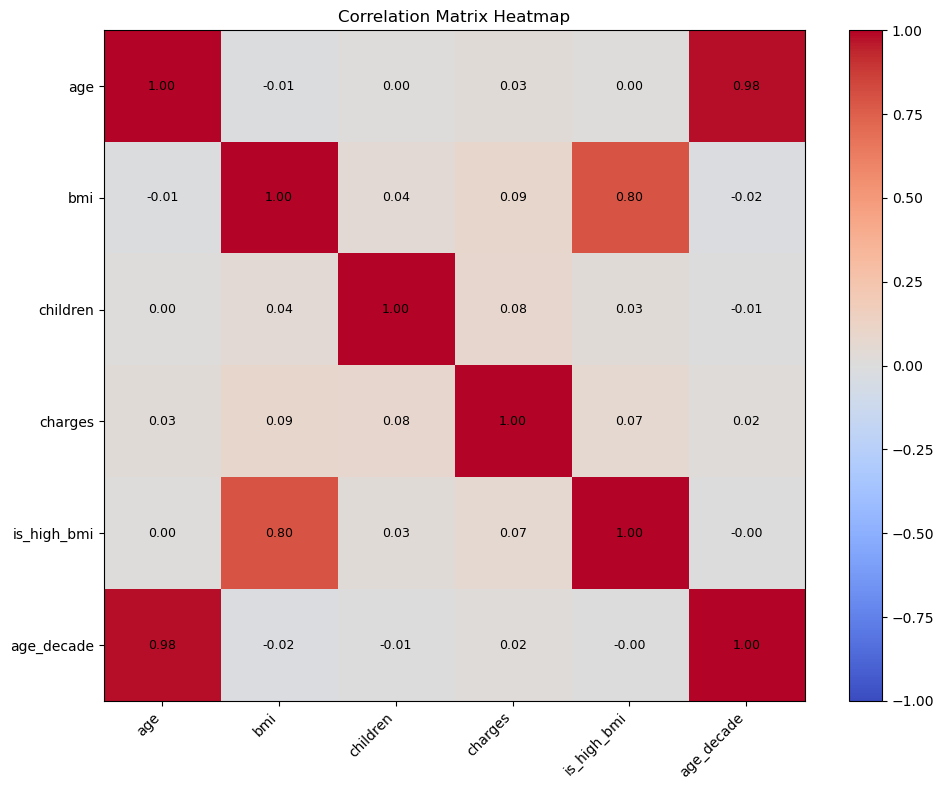


Top 3 numeric features most correlated with charges (by absolute correlation):
1. bmi: 0.0910 (abs: 0.0910)
2. children: 0.0792 (abs: 0.0792)
3. is_high_bmi: 0.0673 (abs: 0.0673)


In [8]:
# Q3.1: correlation matrix for numeric columns
numeric_df = df.select_dtypes(include=[np.number])
corr = numeric_df.corr()
print("Correlation Matrix:")
print(corr)

# Q3.2: visualize with plt.imshow
plt.figure(figsize=(10, 8))
im = plt.imshow(corr, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
plt.colorbar(im)
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha='right')
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title('Correlation Matrix Heatmap')

# Add correlation values as text
for i in range(len(corr.columns)):
    for j in range(len(corr.columns)):
        plt.text(j, i, f'{corr.iloc[i, j]:.2f}', ha='center', va='center', fontsize=9)

plt.tight_layout()
plt.show()

# Q3.3: top 3 numeric features correlated with charges (abs)
charges_corr = corr['charges'].drop('charges').abs().sort_values(ascending=False)
print("\nTop 3 numeric features most correlated with charges (by absolute correlation):")
for i, (feature, correlation) in enumerate(charges_corr.head(3).items(), 1):
    print(f"{i}. {feature}: {corr['charges'][feature]:.4f} (abs: {correlation:.4f})")

---
# Q4 — Simple linear regression (SLR): `charges ~ bmi` (20 points)

1. Split into train/test (`test_size=0.25`, `random_state=RANDOM_SEED`). (3 pts)  
2. Fit `LinearRegression()` predicting `charges` using only `bmi`. (4 pts)  
3. Report slope, intercept, test R², test RMSE, and test MAE. (5 pts)  
4. Plot scatter of `bmi` vs `charges` (train set) with the fitted regression line. (4 pts)  
5. Residual plot on the test set (predicted vs residual). (2 pts)  
6. **Discussion (markdown):** What does the residual plot suggest about model fit and outliers? (2 pts)

In [9]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


In [10]:
# Q4.1: Split
X_slr = df[["bmi"]]
y = df["charges"]
X_train_slr, X_test_slr, y_train, y_test = train_test_split(
    X_slr, y, test_size=0.25, random_state=RANDOM_SEED
)

# Q4.2: Fit model
slr = LinearRegression()
slr.fit(X_train_slr, y_train)

# Q4.3: Report intercept, slope, test R2, test RMSE, test MAE
y_test_pred_slr = slr.predict(X_test_slr)
y_train_pred_slr = slr.predict(X_train_slr)

print("=== Simple Linear Regression Results ===")
print(f"Intercept: {slr.intercept_:.4f}")
print(f"Slope (bmi coefficient): {slr.coef_[0]:.4f}")
print(f"\nTest Set Metrics:")
print(f"  R² Score: {r2_score(y_test, y_test_pred_slr):.4f}")
print(f"  RMSE: {rmse(y_test, y_test_pred_slr):.4f}")
print(f"  MAE: {mean_absolute_error(y_test, y_test_pred_slr):.4f}")

# Save metrics for later comparison
slr_r2 = r2_score(y_test, y_test_pred_slr)
slr_rmse = rmse(y_test, y_test_pred_slr)
slr_mae = mean_absolute_error(y_test, y_test_pred_slr)

=== Simple Linear Regression Results ===
Intercept: 8892.2595
Slope (bmi coefficient): 129.9127

Test Set Metrics:
  R² Score: 0.0131
  RMSE: 10413.0534
  MAE: 8449.6179


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


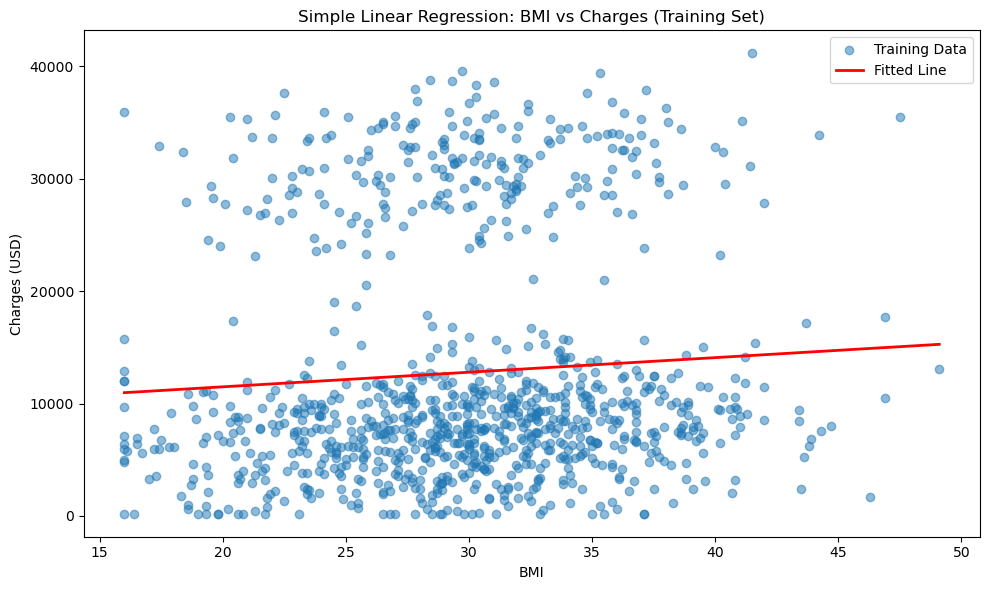

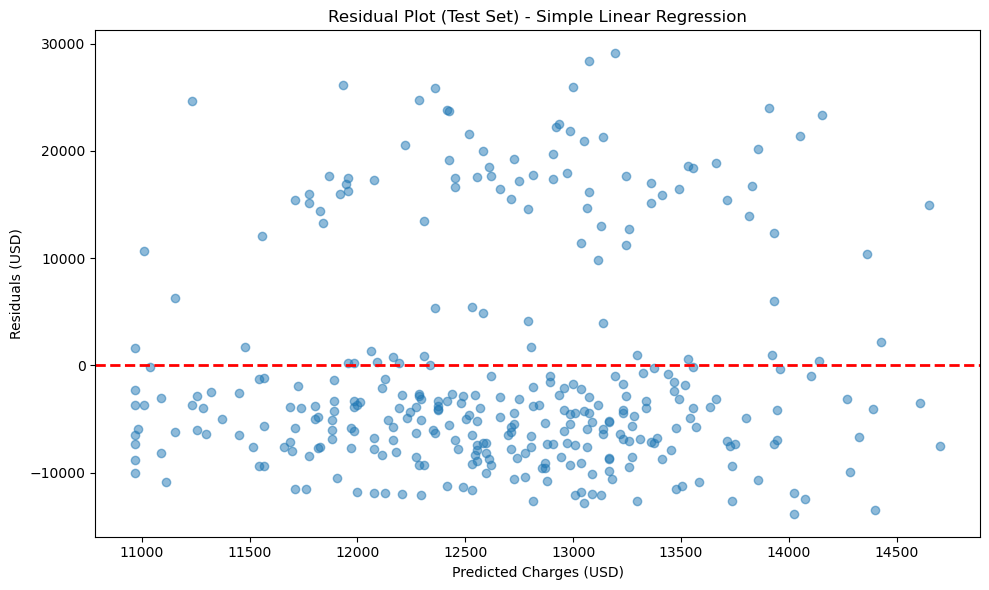

In [11]:
# Q4.4: Plot train scatter + fitted line
plt.figure(figsize=(10, 6))
plt.scatter(X_train_slr, y_train, alpha=0.5, label='Training Data')
bmi_range = np.linspace(X_train_slr['bmi'].min(), X_train_slr['bmi'].max(), 100).reshape(-1, 1)
plt.plot(bmi_range, slr.predict(bmi_range), color='red', linewidth=2, label='Fitted Line')
plt.xlabel('BMI')
plt.ylabel('Charges (USD)')
plt.title('Simple Linear Regression: BMI vs Charges (Training Set)')
plt.legend()
plt.tight_layout()
plt.show()

# Q4.5: Residual plot (test)
residuals = y_test - y_test_pred_slr
plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred_slr, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Predicted Charges (USD)')
plt.ylabel('Residuals (USD)')
plt.title('Residual Plot (Test Set) - Simple Linear Regression')
plt.tight_layout()
plt.show()

**Q4.6 Discussion:**

The residual plot shows a fan shape which means the variance isn't constant (heteroscedasticity). There are also lots of big positive residuals where the model underestimates - these are probably smokers. Basically BMI alone can't explain the charges well, we're missing important variables like smoking status.

---
# Q5 — Multiple linear regression (MLR) with mixed features (25 points)

Use predictors:
- Numeric: `age`, `bmi`, `children`
- Categorical: `sex`, `smoker`, `region`

1. Build a pipeline that:
   - standard-scales numeric features
   - one-hot encodes categorical features
   - fits `LinearRegression()` (10 pts)
2. Fit using the same train/test split rule as Q4. (3 pts)  
3. Report test R², test MAE, and test RMSE. (4 pts)  
4. Extract and print the **top 10 coefficients by absolute value** with feature names. (6 pts)  
5. **Discussion (markdown):** Which feature dominates, and are coefficient signs reasonable? (2 pts)

In [12]:
# Q5.1: Define features
numeric_features = ["age", "bmi", "children"]
categorical_features = ["sex", "smoker", "region"]

# Q5.1: Build preprocessing + pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ]
)

mlr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Q5.2: Split, fit
X = df[numeric_features + categorical_features]
y = df["charges"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_SEED
)
mlr.fit(X_train, y_train)

# Q5.3: Evaluate test R2, RMSE, and MAE
y_test_pred_mlr = mlr.predict(X_test)
mlr_r2 = r2_score(y_test, y_test_pred_mlr)
mlr_rmse = rmse(y_test, y_test_pred_mlr)
mlr_mae = mean_absolute_error(y_test, y_test_pred_mlr)

print("=== Multiple Linear Regression Results ===")
print(f"Test R² Score: {mlr_r2:.4f}")
print(f"Test RMSE: {mlr_rmse:.4f}")
print(f"Test MAE: {mlr_mae:.4f}")

# Q5.4: Top 10 coefficients by abs value
# Get feature names from preprocessor
ohe_feature_names = mlr.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)
feature_names = list(numeric_features) + list(ohe_feature_names)
coefs = mlr.named_steps['regressor'].coef_

# Create DataFrame and sort by absolute value
coef_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefs
})
coef_df['abs_coefficient'] = np.abs(coef_df['coefficient'])
coef_df_sorted = coef_df.sort_values('abs_coefficient', ascending=False)

print("\nTop 10 Coefficients by Absolute Value:")
print(coef_df_sorted.head(10).to_string(index=False))

=== Multiple Linear Regression Results ===
Test R² Score: 0.8766
Test RMSE: 3681.7697
Test MAE: 2915.8045

Top 10 Coefficients by Absolute Value:
         feature  coefficient  abs_coefficient
      smoker_yes 23809.776800     23809.776800
region_southeast -2381.845021      2381.845021
region_southwest -1388.080519      1388.080519
             age   712.444686       712.444686
             bmi   701.248740       701.248740
        children   643.438666       643.438666
region_northwest  -380.961333       380.961333
        sex_male   131.349311       131.349311


**Q5.5 Discussion:**

`smoker_yes` has the biggest coefficient by far, which makes sense since smoking causes lots of health problems. The signs look reasonable - age, bmi, children are all positive (higher = more costs), and sex/region don't matter that much. Note that numeric features are scaled so their coefficients show the effect per standard deviation.

---
# Q6 — Model comparison & reflection (15 points)

1. Create a table comparing **SLR** vs **MLR** using test R², test RMSE, and test MAE. (5 pts)  
2. **Discussion (markdown):**
   - Which model performs better and why? (5 pts)
   - If R² is high but RMSE is still large, what might that indicate? (3 pts)
   - Suggest one next improvement (e.g., log-transform charges, interactions, removing outliers). (2 pts)

In [13]:
# Q6.1: Comparison table using your saved metrics
comparison = pd.DataFrame({
    'Model': ['Simple Linear Regression (BMI only)', 'Multiple Linear Regression'],
    'Test R²': [slr_r2, mlr_r2],
    'Test RMSE': [slr_rmse, mlr_rmse],
    'Test MAE': [slr_mae, mlr_mae]
})

print("Model Comparison:")
comparison

Model Comparison:


,Model,Test R²,Test RMSE,Test MAE
0,Simple Linear Regression (BMI only),0.013112,10413.053375,8449.617856
1,Multiple Linear Regression,0.876626,3681.769736,2915.804481


**Q6.2 Discussion:**

MLR is way better - R² jumped from 0.01 to 0.88 and RMSE dropped from 10k to 3.7k. This is because MLR includes smoker status which is the main factor for medical costs.

If R² is high but RMSE is still large, it could mean the target values are just big numbers (charges in thousands of dollars), or there are some outliers the model can't predict well.

One improvement would be to log-transform charges since they're skewed. This could help with the heteroscedasticity issue too.

---
# Q7 — GenAI usage (max -2 penalty, required)

Answer honestly:
1. Did you use any GenAI tool (ChatGPT, Copilot, etc.)?
2. If yes, what for?
3. What limitations did you notice?

**Q7 Answers:**

1. Yes, I used Copilot a bit for help.

2. Mainly for looking up sklearn syntax and fixing some bugs.

3. Sometimes it gives wrong code so I had to double check everything. Also it doesn't always know what the data looks like so the explanations needed editing.